In [181]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import sys
import scipy.ndimage
import matplotlib.cm
import imageio

In [182]:
sys.path.append('../../Preprocess/')
import CalcParaMaps
import BiasCorrection

In [183]:
biases = {}
stds = {}
cnrs = {}
contrasts = {}
noises = {}
imgNorm = 0.15
nTest = 5

In [184]:
# load ROIs
biasROIs = np.load('/home/dwu/trainData/Noise2Noise/train/ctp/real/evals/rois/std.npy', allow_pickle=True)
stdROIs = np.load('/home/dwu/trainData/Noise2Noise/train/ctp/real/evals/rois/std.npy', allow_pickle=True)
lesionROIs = np.load('/home/dwu/trainData/Noise2Noise/train/ctp/real/evals/rois/lesion.npy', allow_pickle=True)

In [185]:
# read references
refDir = '/home/dwu/trainData/Noise2Noise/train/ctp/real/data/'
imgs = np.load(os.path.join(refDir, 'imgs4d.npy'), allow_pickle=True)[-nTest:] / 1000 / imgNorm
masks = np.load(os.path.join(refDir, 'mask.npy'), allow_pickle=True)[-nTest:]
aifs = np.load(os.path.join(refDir, 'aif.npy'), allow_pickle=True)[-nTest:] / 1000 / imgNorm
vofs = np.load(os.path.join(refDir, 'vof.npy'), allow_pickle=True)[-nTest:] / 1000 / imgNorm
cbfFacs = np.load(os.path.join(refDir, 'cbfFac.npy'), allow_pickle=True)[-nTest:]

In [186]:
# vessel mask from img
for i in range(len(imgs)):
    maskVessel = np.where(np.max(imgs[i], -1) > 0.1 / imgNorm, 1, 0)[...,np.newaxis]
    maskVessel *= masks[i]
    for k in range(maskVessel.shape[0]):
        maskVessel[k,...,0] = scipy.ndimage.morphology.binary_dilation(maskVessel[k,...,0])
    masks[i] *= (1 - maskVessel)

for i in range(len(imgs)):
    imgs[i] *= masks[i]
    
tacs = []
for i in range(len(imgs)):
    tacs.append(imgs[i] - (imgs[i][...,[0]] + imgs[i][...,[1]]) / 2)

In [187]:
for i in range(len(masks)):
    biasROIs[i] *= masks[i]
    stdROIs[i] *= masks[i]
    lesionROIs[i] *= masks[i]

In [188]:
def GetROIMeanStd(imgs, biasROIs, stdROIs):
    means = []
    stds = []
    for i in range(len(imgs)):           
        if biasROIs[i].sum() > 0:
            means.append(np.sum(imgs[i] * biasROIs[i], (0,1,2)) / np.sum(biasROIs[i], (0,1,2)))

        if stdROIs[i].sum() > 0:
            m = np.sum(imgs[i] * stdROIs[i], (0,1,2)) / np.sum(stdROIs[i], (0,1,2))
            var = np.sum((imgs[i] - m)**2 * stdROIs[i], (0,1,2)) / np.sum(stdROIs[i], (0,1,2))
            stds.append(np.sqrt(var))
    
    return np.concatenate(means), np.concatenate(stds)

In [189]:
def GetROIContrastAndNoise(imgs, lesionROIs, stdROIs):
    contrasts = []
    stds = []
    for i in range(len(imgs)):
        if lesionROIs[i].sum() > 0:
            lesion = np.sum(imgs[i] * lesionROIs[i]) / np.sum(lesionROIs[i])
            ref = np.sum(imgs[i] * stdROIs[i]) / np.sum(stdROIs[i])
            std = np.sqrt(np.sum((imgs[i] - ref)**2 * stdROIs[i]) / np.sum(stdROIs[i]))
            
            contrasts.append(ref - lesion)
            stds.append(std)

    return np.array(contrasts), np.array(stds)

In [190]:
# original images
name = 'raw'
m0, s0 = GetROIMeanStd(tacs, biasROIs, biasROIs)
biases[name] = m0 - m0
stds[name] = s0
# cnr for CBF
cbfs = []
for i in range(len(tacs)):
    cbf, _, _ = CalcParaMaps.CalcParaMaps(tacs[i] * masks[i], masks[i], vof = np.copy(vofs[i]), aif = np.copy(aifs[i]))
    cbfs.append((cbf * cbfFacs[i])[...,np.newaxis])
c, s = GetROIContrastAndNoise(cbfs, lesionROIs, stdROIs)
contrasts[name] = c
noises[name] = s
cnrs[name] = c / s

In [191]:
# gaussian
name = 'gauss'
gauss = np.load('/home/dwu/trainData/Noise2Noise/train/ctp/real/gaussian/Gaussian_std_2.npy', allow_pickle=True)
for i in range(len(masks)):
    gauss[i] *= masks[i]
m, s = GetROIMeanStd(gauss, biasROIs, biasROIs)
biases[name] = m - m0
stds[name] = s
# cnr for CBF
cbfs = []
for i in range(len(gauss)):
    cbf, _, _ = CalcParaMaps.CalcParaMaps(gauss[i] * masks[i], masks[i], vof = np.copy(vofs[i]), aif = np.copy(aifs[i]))
    cbfs.append((cbf * cbfFacs[i])[...,np.newaxis])
c, s = GetROIContrastAndNoise(cbfs, lesionROIs, stdROIs)
contrasts[name] = c
noises[name] = s
cnrs[name] = c / s

In [192]:
# tips
name = 'tips'
tips = np.load('/home/dwu/trainData/Noise2Noise/train/ctp/real/tips/TIPS_sigma_0.075_2.npy', allow_pickle=True)
for i in range(len(masks)):
    tips[i] *= masks[i]
m, s = GetROIMeanStd(tips, biasROIs, biasROIs)
biases[name] = m - m0
stds[name] = s
# cnr for CBF
cbfs = []
for i in range(len(tips)):
    cbf, _, _ = CalcParaMaps.CalcParaMaps(tips[i] * masks[i], masks[i], vof = np.copy(vofs[i]), aif = np.copy(aifs[i]))
    cbfs.append((cbf * cbfFacs[i])[...,np.newaxis])
c, s = GetROIContrastAndNoise(cbfs, lesionROIs, stdROIs)
contrasts[name] = c
noises[name] = s
cnrs[name] = c / s

In [193]:
# tv
# no biase and std
name = 'tv'
cbfs = np.load('/home/dwu/trainData/Noise2Noise/train/ctp/real/tv/TV_beta_1e-3_1e-4.npz', allow_pickle=True)['cbf']
for i in range(len(cbfs)):
    cbfs[i] = cbfs[i][...,np.newaxis] * masks[i]

c, s = GetROIContrastAndNoise(cbfs, lesionROIs, stdROIs)
contrasts[name] = c
noises[name] = s
cnrs[name] = c / s

In [194]:
# Noise2Noise
name = 'n2n'
n2n = np.load('/home/dwu/trainData/Noise2Noise/train/ctp/real/beta_37.5/tmp/iodines.npy', allow_pickle=True)[-nTest:] * 0.025 / imgNorm
for i in range(len(masks)):
    n2n[i] *= masks[i]
#     n2n[i] = BiasCorrection.BiasCorrection(n2n[i], tacs[i], masks[i])
m, s = GetROIMeanStd(n2n, biasROIs, biasROIs)
biases[name] = m - m0
stds[name] = s
# cnr for CBF
cbfs = []
for i in range(len(n2n)):
    cbf, _, _ = CalcParaMaps.CalcParaMaps(n2n[i] * masks[i], masks[i], vof = np.copy(vofs[i]), aif = np.copy(aifs[i]))
    cbfs.append((cbf * cbfFacs[i])[...,np.newaxis])
c, s = GetROIContrastAndNoise(cbfs, lesionROIs, stdROIs)
contrasts[name] = c
noises[name] = s
cnrs[name] = c / s

In [195]:
# Supervised
name = 'sup'
sup = np.load('/home/dwu/trainData/Noise2Noise/train/ctp/real/supervised/supervised_beta_37.5.npy', allow_pickle=True) * 0.025 / imgNorm
for i in range(len(masks)):
    sup[i] *= masks[i]
    sup[i] = BiasCorrection.BiasCorrection(sup[i], tacs[i], masks[i])
m, s = GetROIMeanStd(sup, biasROIs, biasROIs)
biases['sup'] = m - m0
stds['sup'] = s
# cnr for CBF
cbfs = []
for i in range(len(sup)):
    cbf, _, _ = CalcParaMaps.CalcParaMaps(sup[i] * masks[i], masks[i], vof = np.copy(vofs[i]), aif = np.copy(aifs[i]))
    cbfs.append((cbf * cbfFacs[i])[...,np.newaxis])
c, s = GetROIContrastAndNoise(cbfs, lesionROIs, stdROIs)
contrasts[name] = c
noises[name] = s
cnrs[name] = c / s

In [179]:
for k in cnrs:
    print (k, '%.2f, %.2f, %.2f'%(np.mean(contrasts[k]), np.mean(noises[k]), np.mean(cnrs[k])))

raw 48.27, 150.07, 0.30
gauss 100.76, 32.32, 2.83
tips 100.04, 34.20, 2.64
tv 158.54, 37.69, 5.35
n2n 100.25, 25.90, 3.46
sup 86.05, 29.21, 2.57


In [180]:
contrasts

{'raw': array([104.28045777,  33.33196041,   2.74998233,  52.73350106]),
 'gauss': array([226.00065219,  63.17630723,  35.57115808,  78.28562449]),
 'tips': array([226.27894764,  62.19287148,  34.32401152,  77.37498862]),
 'tv': array([374.26928051,  89.8076641 ,  58.76110414, 111.33437367]),
 'n2n': array([236.63506357,  62.88693655,  19.35476295,  82.14314309]),
 'sup': array([203.30788377,  45.36678081,  16.01444174,  79.50389557])}

In [196]:
for k in biases:
    print (k, '%.2f'%(np.abs(biases[k]).mean() * 150), '%.2f'%(stds[k].mean() * 150))

raw 0.00 8.74
gauss 0.11 1.22
tips 0.10 1.36
n2n 0.13 0.73
sup 0.32 0.83


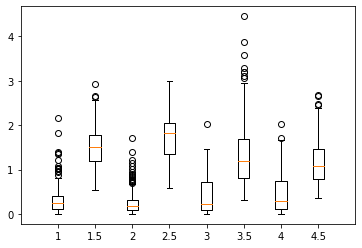

In [40]:
for i, k in enumerate(biases):
    if k == 'raw':
        continue
    plt.boxplot(np.abs(biases[k]) * 150, positions = [i])
    plt.boxplot(stds[k] * 150, positions = [i + 0.5])

In [197]:
def SetBPlotColor(bplot, color):
    for patch in bplot['boxes']:
        patch.set_facecolor(color)
    for median in bplot['medians']:
        median.set_color('black')

In [198]:
# save all the images
outDir = '/home/dwu/trainData/Noise2Noise/train/ctp/results/real/quantifications'
if not os.path.exists(outDir):
    os.makedirs(outDir)
np.savez(os.path.join(outDir, 'bias_std_cnr'), biases = biases, stds = stds, cnrs = cnrs)

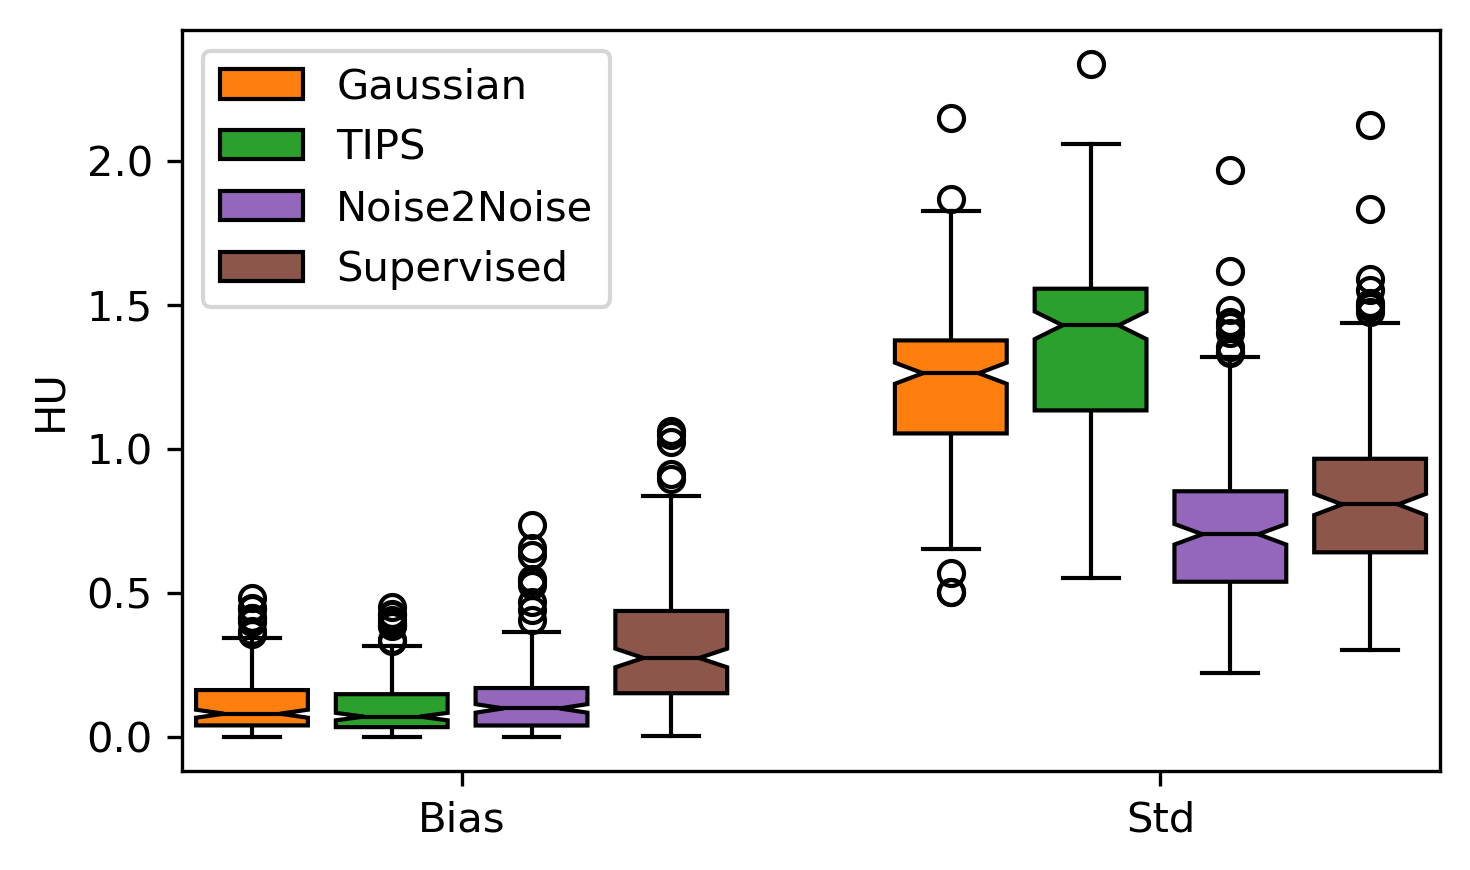

In [199]:
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
colorList = [cycle[1], cycle[2], cycle[4], cycle[5]]
bplots = []
plt.figure(figsize = [5,3], dpi=300)
for i, k in enumerate(biases):
    if k == 'raw':
        continue
    bplot = plt.boxplot(np.abs(biases[k]) * 150, positions = [i], widths=0.8, patch_artist=True, notch=True)
    SetBPlotColor(bplot, colorList[i-1])
    bplots.append(bplot)

for i, k in enumerate(biases):
    if k == 'raw':
        continue
    bplot = plt.boxplot(stds[k] * 150, positions = [i + len(biases)], widths=0.8, patch_artist=True, notch=True)
    SetBPlotColor(bplot, colorList[i-1])

plt.ylabel('HU')
plt.xticks([2.5, 7.5], ['Bias', 'Std'])
plt.legend([bplot['boxes'][0] for bplot in bplots], ['Gaussian', 'TIPS', 'Noise2Noise', 'Supervised'])
plt.tight_layout()
plt.savefig(os.path.join(outDir, 'bias_std.png'))